<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/Project_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
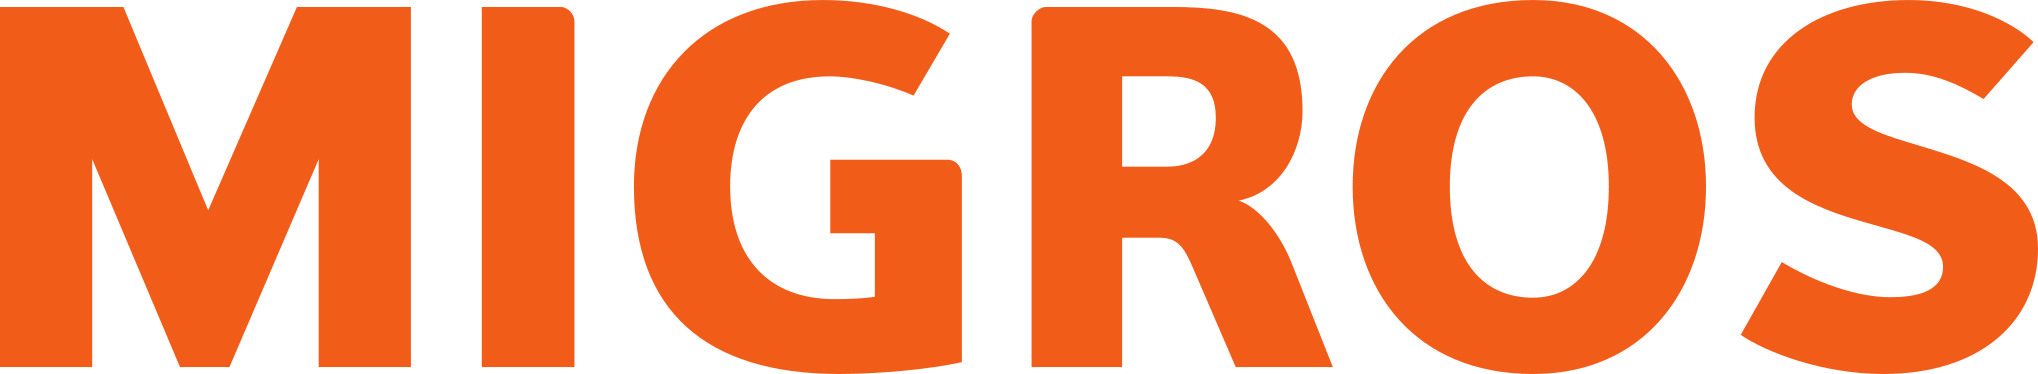
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.

#Report 📋
  1) At first we submitted a simple logistic regression without data cleaning which gave us a satisfying accuracy of **0.805** on AICrowd
  
  2) We cleaned the text by deleting unecessary elements, then applied a logistic regression with cross validation (LRCV). Although the model built on the train data is pretty good, the accuracy on AICrowd got lower: **0.797**

  3) We used the Random Forest Classifier (RFC) and its model accuracy seemed very promising (0.97 for the train data) however, whilst submitting to AICrowd we got only a result of **0.77**. It seems like we are missing an important point as our accuracy keeps getting lower. Perhaps our model is overfitting the train data, thus we have to correct our parameters

#Importing useful tools 🧰

In [1]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [2]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en
import spacy
from spacy import displacy

In [3]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 4.3MB/s 


In [4]:
from textblob import TextBlob


In [5]:
#clear output
%%capture 

#Importing useful extensions
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

import string
from spellchecker import SpellChecker

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


#Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [6]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [7]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(6)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
5,10020,twister,NaN,Brain twister let drop up telly structuring ca...


In [8]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

#Exploratory data analysis 🕵️

1.   Base rate
2.   List item



####1. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [9]:
#Base rate of the train df
df_train['target'].value_counts() /len(df_train) 

#The base rate of this dataframe is 0.572

0    0.571936
1    0.428064
Name: target, dtype: float64

In [10]:
#Are there null values ?
print(df_train.text.isnull().sum())
print(df_train.keyword.isnull().sum())

0
55


#Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column

In [11]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

# Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
# Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
# Remove words with two letters or less
    mytokens = [ word for word in mytokens if len(word)>2 ]   
# Return preprocessed list of tokens
    return mytokens
#demo
review = df_train["text"].sample()
review.values[0]


"@canagal Good to hear it's back.. that storm's been given you guys trouble though :( ^SJ"

In [12]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Logistic regression and pipeline

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.



In [13]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [15]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fb1bedfba60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

####Accuracy

In [16]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8937
CONFUSION MATRIX:
[[2882   79]
 [ 471 1744]]


In [17]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7884
CONFUSION MATRIX:
[[656  84]
 [190 365]]


####Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [18]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value = 'nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

0

In [19]:
#Using keyword in the model
features = ['keyword', 'text']

X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [20]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])



In [21]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fb1bedfba60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

In [22]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.7361
CONFUSION MATRIX:
[[2374  587]
 [ 779 1436]]


#Data cleaning 🧼
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [23]:
#Need to replace NaN values by blank spaces otherwise some funtions wont run
df_test['text'] = df_test['text'].replace(np.nan, '')


In [24]:

#Clean duplicates
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)

#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#removing hashtags
def remove_hash(text):
  text = re.sub('#','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_hash(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hash(x))

#removing amp
def amp(text):
  text = re.sub('&amp;', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: amp(x))
df_test['text'] = df_test['text'].apply(lambda x: amp(x))

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))

#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#removing noises
def remove_noise(text):
  text = re.sub('RT', '', text)
  text = re.sub('rT', '', text)
  text = re.sub('Rt', '', text)
  text = re.sub('rt', '', text)
  text = re.sub('IB', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))

In [25]:
#Spellchecking the text (it takes too much time)
#df_train.text.apply(lambda txt: ''.join(TextBlob(txt).correct()))


In [26]:
#Convert dataframes to csv file to check if the rows of text looks good
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

#Using different classifiers 👨‍💻

We tried different classifier to know which one could predict the best our model

##Logistic regression with cross validation

In [27]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y )

In [28]:
#Logistic regressin cross validation
from sklearn.linear_model import LogisticRegressionCV
LRCV = LRCV = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000, random_state=42)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LRCV)])



In [29]:
#Fit
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function spacy_tokenizer at 0x7fb1bedfba60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=Fal

In [30]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9313
CONFUSION MATRIX:
[[2868   72]
 [ 279 1890]]


In [31]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7934
CONFUSION MATRIX:
[[629 107]
 [157 385]]


In [32]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 1, 0, 1])

In [33]:
sample_submission.target = target_test
sample_submission.to_csv('submission-12.csv', index=False)

##Random forest classifier 🌳🌳🌳
According to the documentation, the RFC looks like the most fitting classifier for our case. Thus we allocated a lot of ressources to improve its accuracy: in the section below there is a take on parameters tuning for RFC.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
#Define classifier
RFC = RandomForestClassifier(n_estimators = 16,max_depth = 60,random_state =42)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])

In [37]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=60, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [38]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8381
CONFUSION MATRIX:
[[2933    1]
 [ 826 1349]]


In [39]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7512
CONFUSION MATRIX:
[[694  48]
 [270 266]]


In [40]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 0, 0, 1])

In [41]:
sample_submission.target = target_test
sample_submission.to_csv('submission-13.csv', index=False)

####Plot different values of parameters to find which one is optimal
####1. n_estimator

In [42]:
#packages needed for graphs
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [47]:
#Create array of values for n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#Build function to test value of array in the model
train_results = []
test_results = []
for estimator in n_estimators:
   RFC = RandomForestClassifier(n_estimators=estimator, n_jobs=-1) 
   pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])
   pipe.fit(X_train, y_train)
   #Training data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


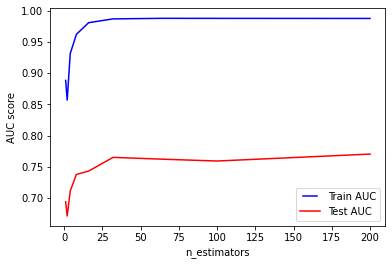

In [48]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
#We can see below a maximum for is between [25;50]

####2. max_depth

In [49]:
#Tune max_depths parameters, analyze value between 1 and 100
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
#Creating a function
for max_depth in max_depths:
   RFC = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   
   pipe.fit(X_train, y_train)
   
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

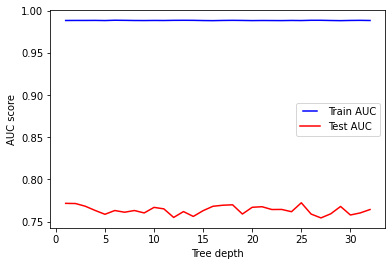

In [50]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

####3. min_samples_split

In [ ]:
#Want to know what values between 10% or 100% of the samples is needed
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
#the function
for min_samples_split in min_samples_splits:
   RFC = RandomForestClassifier(min_samples_split=min_samples_split)
   #Train data curve
   pipe.fit(X_train, y_train)
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

####4. max_features

In [ ]:
#nb of features to consider when looking for the best split
max_features = list(range(1,df_train.shape[1]))
train_results = []
test_results = []
#the function
for max_feature in max_features:
   RFC = RandomForestClassifier(max_features=max_feature)   
   pipe.fit(x_train, y_train)
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r, label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

##Submission 👀
This is the code that we use to create the submission. To use it, we can just copy/paste it below the classifier of our choice and rename the .csv file.

In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

In [ ]:
sample_submission.assign(target = target_test)
sample_submission.to_csv('submission-n.csv', index=False)